# TP Coding a GAN in Pytorch

Author : Alasdair Newson

alasdair.newson@telecom-paris.fr

## Objective:

The goal of this TP is to explore GANs applied to the mnist (and possibly cifar10) datasets.

We will start with the mnist dataset.

### Your task:
You need to add the missing parts in the code (parts between # --- START CODE HERE and # --- END CODE HERE or # FILL IN CODE)

First of all, let's load some packages

In [40]:

import matplotlib.pyplot as plt
import sys
import numpy as np
import pickle
import copy
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

def pytorch_to_numpy(x):
  return x.detach().numpy()


# Decide which device we want to run on
if (torch.cuda.is_available()):
  device = torch.device("cuda:0")
else:
  device = "cpu"


## 1/ Loading the data

We define a function to load the mnist or cifar10 datasets. Note, we normalise the data between -1 and 1 here (this is often the case for GANs).

In [4]:
pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [41]:

# create a random seed for reproducible results
random_seed = 1
torch.manual_seed(random_seed)

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

# MNIST Dataset
mnist_trainset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
mnist_testset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

#create data loader with smaller dataset size
max_mnist_size = 1000
mnist_trainset_reduced = torch.utils.data.random_split(mnist_trainset, [max_mnist_size, len(mnist_trainset)-max_mnist_size])[0] 
mnist_train_loader = torch.utils.data.DataLoader(mnist_trainset_reduced, batch_size=64, shuffle=True)

# download test dataset
max_mnist_size = 512
mnist_testset_reduced = torch.utils.data.random_split(mnist_testset, [max_mnist_size, len(mnist_testset)-max_mnist_size])[0] 
mnist_test_loader = torch.utils.data.DataLoader(mnist_testset_reduced, batch_size=64, shuffle=True)



In [42]:
n_rows = mnist_trainset_reduced.dataset.train_data.shape[1]
n_cols = mnist_trainset_reduced.dataset.train_data.shape[2]
n_channels = 1
n_pixels = n_rows*n_cols

img_shape = (n_rows, n_cols, n_channels)

c:\Users\march\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


## 2/ GAN parameters

In [43]:

## GAN parameters
z_dim = 10
batch_size = 64
## parameters for training
n_epochs = 400
n_iters_inner=1	#number of internal loops
sample_interval=100
# Learning rate for optimizers
lr = 0.0002
beta_1 = 0.5

# hidden dimensions : careful, the order here is with respect to the generator, and the discriminator is in the opposite order
h_dim_1 = 256
h_dim_2 = 512

## 3/ Model architecture

Now, we define the model architecture.

For the first dataset, mnist, we are going to use fully connected layers. Implement the following architecture, for the generator and the discriminator :

Generator :
- Dense layer, to size 256
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, to size 512
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 784
- Tanh activation
- Reshape to size $28 \times 28 \times 1$

Discriminator :
- Flatten
- Dense layer, to size 512
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 256
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 1
- Sigmoid activation

In [44]:
# Generator Code

class Generator(nn.Module):
  def __init__(self, z_dim, h_dim_1, h_dim_2, n_rows,n_cols,n_channels):
    super(Generator, self).__init__()
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.n_channels = n_channels
    self.n_pixels = (self.n_rows)*(self.n_cols)
    self.h_dim_1 = h_dim_1
    self.h_dim_2 = h_dim_2
    self.z_dim = z_dim

    self.fc1 = nn.Linear(self.z_dim, h_dim_1)
    self.fc2 = nn.Linear(h_dim_1, h_dim_2)
    self.fc3 = nn.Linear(h_dim_2, self.n_pixels)
  def forward(self, z):
    y = F.leaky_relu(self.fc1(z), negative_slope=0.2)
    y = F.leaky_relu(self.fc2(y), negative_slope=0.2)
    y = torch.tanh(self.fc3(y))
    y = y.view(y.shape[0], self.n_channels, self.n_rows, self.n_cols)
    
    return(y)


In [45]:

class Discriminator(nn.Module):
  def __init__(self, h_dim_2, h_dim_1, z_dim, n_rows,n_cols,n_channels):
    super(Discriminator, self).__init__()

    self.n_rows = n_rows
    self.n_cols = n_cols
    self.n_channels = n_channels
    self.n_pixels = (self.n_rows)*(self.n_cols)
    self.h_dim_1 = h_dim_1
    self.h_dim_2 = h_dim_2
    self.z_dim = z_dim

    self.fc1 = nn.Linear( self.n_pixels, h_dim_2)
    self.fc2 = nn.Linear(h_dim_2, h_dim_1)
    self.fc3 = nn.Linear(h_dim_1, 1)

  def forward(self, x):
    y = x.view(x.shape[0], self.n_pixels)
    y = F.leaky_relu(self.fc1(y), negative_slope=0.2)
    y = F.leaky_relu(self.fc2(y), negative_slope=0.2)
    y = torch.sigmoid(self.fc3(y))
    return y




Create generator and discriminator 

In [46]:
gen_model = Generator(z_dim, h_dim_1, h_dim_2, n_rows,n_cols,n_channels)
# Print the model
print(gen_model)

disc_model = Discriminator(h_dim_2, h_dim_1, z_dim, n_rows,n_cols,n_channels)
# Print the model
print(disc_model)

Generator(
  (fc1): Linear(in_features=10, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=784, bias=True)
)
Discriminator(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)


## 4/ Loss function


The GAN loss function is the following :
\begin{equation}
	\min_{G} \max_{D} \mathbb{E}_{x \in p_{data}} \left[ \log D(x)\right] +
	\mathbb{E}_{z \in p_{z}}\left[ \log \left( 1 - D(G(z)) \right)\right],
\end{equation}
where $G$ is the generator, $D$ is the discriminator, $z$ is the latent code, which follows a normal distribution.

You should notice that this is extremely similar to the binary cross-entropy function. Therefore, there is an intelligent way to train the discriminator : we give it first a batch of real images, and label them as real, and secondly we give a batch of fake images and label them as fake. Therefore, the discriminator training itself is done in two sequential steps (first true, then fake). If the labels are correctly chosen (further on, during training), you can (and __should__) use the binary cross-entropy function.

The generator loss, however, must be specified as :
- $mean(\log(1-D(G(z))))$

You can use the ```torch.mean``` function for this purpose.


The training is carried out sequentially : first we execute a few training steps on the discriminator, and then one on the generator. Therefore, we use two loops : one to train the discriminator (the internal loop) and one to train the generator (external loop, ie. the number of epochs). The GAN training algorithm is as follows :

- For $i=0$ to $n-1$
  - For $j=0$ to $m-1$
    - $x \leftarrow$ random batch of data
    - $z \leftarrow$ random batch of latent codes
    - Train discriminator on real images $x$
    - Train discriminator on fake images $G(z)$
  - $z \leftarrow$ random batch of latent codes
  - Train discriminator on fake images $G(z)$



In [47]:
# Setup Adam optimizers for both G and D
optimizer_disc = optim.Adam(disc_model.parameters(), lr=lr, betas=(beta_1, 0.999))
optimizer_gen = optim.Adam(gen_model.parameters(), lr=lr, betas=(beta_1, 0.999))

# criterion used for the discriminator loss
bce_criterion = nn.BCELoss()

# criterion used for the generator loss
def loss_fn_gen(d_gen_data):
  loss_gen = torch.mean(torch.log(1-d_gen_data))
  return loss_gen

### Sampling function

We now create a function to sample several images during training (to follow the convergence of the network)

In [48]:

def sample_images(generator,z_dim, rand_seed=30):
  #np.random.seed(rand_seed)
  r, c = 5, 5
  z_random = torch.randn(r * c, 1, z_dim, dtype=torch.float, device=device) #np.random.normal(0, 1, (r * c, z_dim))
  
  gen_imgs = np.transpose( generator(z_random).cpu().detach().numpy() , (0,2,3,1))

  # Rescale images 0 - 1
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      #black and white images
      if(gen_imgs.shape[3] == 1):
        axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
      elif(gen_imgs.shape[3] == 3):   #colour images
        gen_imgs_temp = gen_imgs.copy()
        gen_imgs_temp = 255.*np.clip(gen_imgs_temp,0.0,1.0) 
        axs[i,j].imshow(gen_imgs_temp[cnt, :,:,:].astype(np.uint8))
      else:
        print('Error, unsupported channel size. Dude, I don''t know what you want me to do.\
            I can''t handle this data. You''ve made me very sad ...')
      axs[i,j].axis('off')
      cnt += 1
  plt.show()

## 5/ Training

We are now ready to train the network. Here is the training algorithm again :

- For $i=0$ to $n-1$
  - For $j=0$ to $m-1$
    - $x \leftarrow$ random batch of data
    - $z \leftarrow$ random batch of latent codes
    - Train discriminator on real images $x$
    - Train discriminator on fake images $G(z)$
  - $z \leftarrow$ random batch of latent codes
  - Train discriminator on fake images $G(z)$

You can use ```np.random.normal``` to create a batch of random latent codes, and ```np.random.randint``` to create a batch of random images.

You can then train the discriminator and the generator using the ```train_on_batch``` function.

We do not worry here about looping over the whole database : just create a random batch at each iteration.

Starting Training
[0/400][0/16] 	Loss_D: 1.4496	Loss_G: -0.6679	D(x): 0.4578	D(G(z)): 0.4873


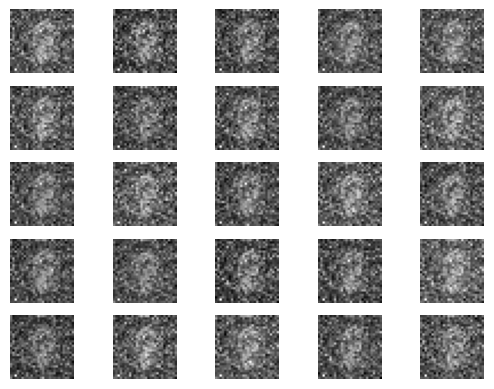

[1/400][0/16] 	Loss_D: 0.9901	Loss_G: -0.7505	D(x): 0.8565	D(G(z)): 0.5656
[2/400][0/16] 	Loss_D: 1.1970	Loss_G: -0.7486	D(x): 0.7329	D(G(z)): 0.5868
[3/400][0/16] 	Loss_D: 1.1537	Loss_G: -0.5634	D(x): 0.7272	D(G(z)): 0.5647
[4/400][0/16] 	Loss_D: 1.2788	Loss_G: -0.6235	D(x): 0.6754	D(G(z)): 0.5863
[5/400][0/16] 	Loss_D: 1.8253	Loss_G: -0.4812	D(x): 0.8395	D(G(z)): 0.8005
[6/400][0/16] 	Loss_D: 0.3287	Loss_G: -0.1628	D(x): 0.8797	D(G(z)): 0.1806
[7/400][0/16] 	Loss_D: 0.2597	Loss_G: -0.0994	D(x): 0.9187	D(G(z)): 0.1539
[8/400][0/16] 	Loss_D: 0.6682	Loss_G: -0.2498	D(x): 0.7260	D(G(z)): 0.2920
[9/400][0/16] 	Loss_D: 0.0741	Loss_G: -0.0347	D(x): 0.9673	D(G(z)): 0.0396
[10/400][0/16] 	Loss_D: 0.0690	Loss_G: -0.0376	D(x): 0.9759	D(G(z)): 0.0426
[11/400][0/16] 	Loss_D: 0.3066	Loss_G: -0.2674	D(x): 0.8989	D(G(z)): 0.1278
[12/400][0/16] 	Loss_D: 0.9199	Loss_G: -0.5233	D(x): 0.6842	D(G(z)): 0.3779
[13/400][0/16] 	Loss_D: 1.1327	Loss_G: -0.5044	D(x): 0.6558	D(G(z)): 0.4766
[14/400][0/16] 	Loss_

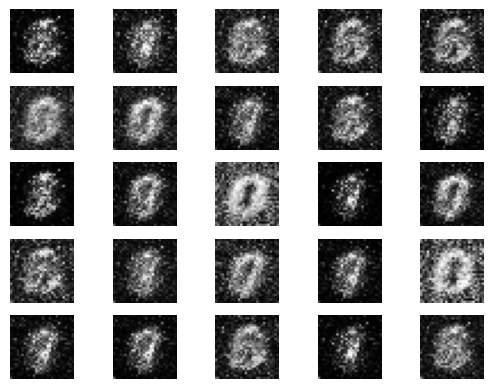

[26/400][0/16] 	Loss_D: 0.9006	Loss_G: -0.4844	D(x): 0.5488	D(G(z)): 0.1912
[27/400][0/16] 	Loss_D: 0.7043	Loss_G: -0.2592	D(x): 0.7559	D(G(z)): 0.3180
[28/400][0/16] 	Loss_D: 1.1555	Loss_G: -0.1728	D(x): 0.9184	D(G(z)): 0.6355
[29/400][0/16] 	Loss_D: 0.7759	Loss_G: -0.2604	D(x): 0.7556	D(G(z)): 0.3588
[30/400][0/16] 	Loss_D: 0.8444	Loss_G: -0.2493	D(x): 0.6058	D(G(z)): 0.2073
[31/400][0/16] 	Loss_D: 0.9010	Loss_G: -0.3595	D(x): 0.6651	D(G(z)): 0.3438
[32/400][0/16] 	Loss_D: 0.9789	Loss_G: -0.4212	D(x): 0.6921	D(G(z)): 0.4094
[33/400][0/16] 	Loss_D: 0.8587	Loss_G: -0.2689	D(x): 0.7132	D(G(z)): 0.3686
[34/400][0/16] 	Loss_D: 0.8568	Loss_G: -0.2071	D(x): 0.7711	D(G(z)): 0.4301
[35/400][0/16] 	Loss_D: 0.9164	Loss_G: -0.1681	D(x): 0.8167	D(G(z)): 0.4831
[36/400][0/16] 	Loss_D: 0.8056	Loss_G: -0.2634	D(x): 0.7383	D(G(z)): 0.3555
[37/400][0/16] 	Loss_D: 1.0069	Loss_G: -0.3767	D(x): 0.6055	D(G(z)): 0.3462
[38/400][0/16] 	Loss_D: 0.6670	Loss_G: -0.1003	D(x): 0.9228	D(G(z)): 0.4305
[39/400][0/1

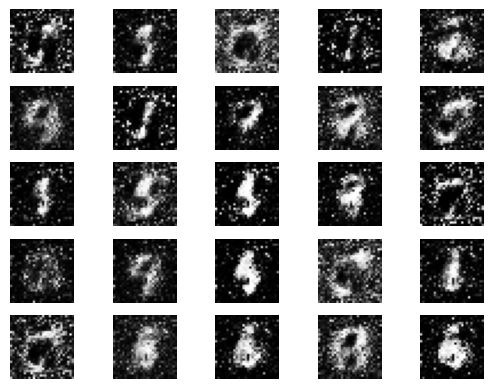

[51/400][0/16] 	Loss_D: 0.5711	Loss_G: -0.2851	D(x): 0.7580	D(G(z)): 0.2049
[52/400][0/16] 	Loss_D: 1.1627	Loss_G: -0.0450	D(x): 0.9348	D(G(z)): 0.6206
[53/400][0/16] 	Loss_D: 0.8768	Loss_G: -0.4341	D(x): 0.5707	D(G(z)): 0.1647
[54/400][0/16] 	Loss_D: 1.0044	Loss_G: -0.3687	D(x): 0.4658	D(G(z)): 0.0234
[55/400][0/16] 	Loss_D: 1.3432	Loss_G: -0.5676	D(x): 0.4068	D(G(z)): 0.0342
[56/400][0/16] 	Loss_D: 0.6558	Loss_G: -0.3824	D(x): 0.6484	D(G(z)): 0.1363
[57/400][0/16] 	Loss_D: 1.0630	Loss_G: -0.2767	D(x): 0.4764	D(G(z)): 0.0715
[58/400][0/16] 	Loss_D: 1.1496	Loss_G: -0.6638	D(x): 0.4392	D(G(z)): 0.0788
[59/400][0/16] 	Loss_D: 0.4815	Loss_G: -0.2079	D(x): 0.8052	D(G(z)): 0.1956
[60/400][0/16] 	Loss_D: 0.4108	Loss_G: -0.1265	D(x): 0.8380	D(G(z)): 0.1823
[61/400][0/16] 	Loss_D: 1.2819	Loss_G: -0.7247	D(x): 0.4176	D(G(z)): 0.0363
[62/400][0/16] 	Loss_D: 1.0781	Loss_G: -0.6574	D(x): 0.4663	D(G(z)): 0.0576
[63/400][0/16] 	Loss_D: 0.5113	Loss_G: -0.2742	D(x): 0.7087	D(G(z)): 0.0868
[64/400][0/1

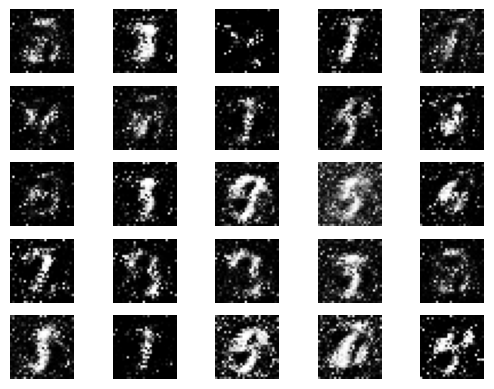

[76/400][0/16] 	Loss_D: 0.4158	Loss_G: -0.1012	D(x): 0.8701	D(G(z)): 0.2175
[77/400][0/16] 	Loss_D: 0.4115	Loss_G: -0.2332	D(x): 0.7370	D(G(z)): 0.0566
[78/400][0/16] 	Loss_D: 0.7257	Loss_G: -0.3141	D(x): 0.6242	D(G(z)): 0.1428
[79/400][0/16] 	Loss_D: 1.4873	Loss_G: -0.0736	D(x): 0.9460	D(G(z)): 0.7253
[80/400][0/16] 	Loss_D: 0.4410	Loss_G: -0.2153	D(x): 0.7716	D(G(z)): 0.1282
[81/400][0/16] 	Loss_D: 0.5801	Loss_G: -0.2922	D(x): 0.6642	D(G(z)): 0.0619
[82/400][0/16] 	Loss_D: 0.4871	Loss_G: -0.1006	D(x): 0.8804	D(G(z)): 0.2858
[83/400][0/16] 	Loss_D: 0.4597	Loss_G: -0.0945	D(x): 0.8743	D(G(z)): 0.2526
[84/400][0/16] 	Loss_D: 0.4255	Loss_G: -0.1982	D(x): 0.8184	D(G(z)): 0.1704
[85/400][0/16] 	Loss_D: 0.3626	Loss_G: -0.0372	D(x): 0.9506	D(G(z)): 0.2470
[86/400][0/16] 	Loss_D: 0.6319	Loss_G: -0.0669	D(x): 0.8997	D(G(z)): 0.3531
[87/400][0/16] 	Loss_D: 1.9818	Loss_G: -0.4659	D(x): 0.2824	D(G(z)): 0.0130
[88/400][0/16] 	Loss_D: 0.4544	Loss_G: -0.1202	D(x): 0.9306	D(G(z)): 0.2901
[89/400][0/1

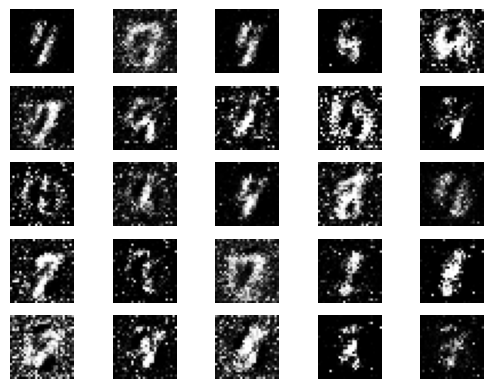

[101/400][0/16] 	Loss_D: 0.5013	Loss_G: -0.4890	D(x): 0.7053	D(G(z)): 0.0516
[102/400][0/16] 	Loss_D: 0.2848	Loss_G: -0.1143	D(x): 0.8585	D(G(z)): 0.0961
[103/400][0/16] 	Loss_D: 0.8122	Loss_G: -0.5154	D(x): 0.5705	D(G(z)): 0.0314
[104/400][0/16] 	Loss_D: 1.3417	Loss_G: -0.6990	D(x): 0.4338	D(G(z)): 0.0202
[105/400][0/16] 	Loss_D: 0.9072	Loss_G: -0.0209	D(x): 0.9475	D(G(z)): 0.5318
[106/400][0/16] 	Loss_D: 0.3449	Loss_G: -0.1444	D(x): 0.8697	D(G(z)): 0.1561
[107/400][0/16] 	Loss_D: 0.4956	Loss_G: -0.3718	D(x): 0.8521	D(G(z)): 0.2078
[108/400][0/16] 	Loss_D: 0.4933	Loss_G: -0.0333	D(x): 0.9247	D(G(z)): 0.3047
[109/400][0/16] 	Loss_D: 0.8856	Loss_G: -0.0366	D(x): 0.9042	D(G(z)): 0.4952
[110/400][0/16] 	Loss_D: 0.9188	Loss_G: -0.0241	D(x): 0.9426	D(G(z)): 0.5349
[111/400][0/16] 	Loss_D: 0.5151	Loss_G: -0.0649	D(x): 0.8876	D(G(z)): 0.2992
[112/400][0/16] 	Loss_D: 0.9357	Loss_G: -0.3672	D(x): 0.5789	D(G(z)): 0.0371
[113/400][0/16] 	Loss_D: 0.6787	Loss_G: -0.0789	D(x): 0.8980	D(G(z)): 0.3962

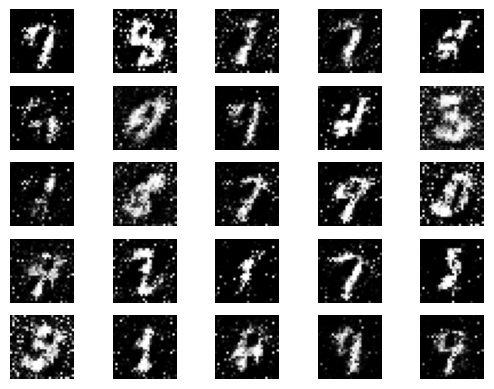

[126/400][0/16] 	Loss_D: 0.4429	Loss_G: -0.1694	D(x): 0.7767	D(G(z)): 0.1093
[127/400][0/16] 	Loss_D: 0.4393	Loss_G: -0.1007	D(x): 0.8510	D(G(z)): 0.1969
[128/400][0/16] 	Loss_D: 0.9118	Loss_G: -0.5260	D(x): 0.5671	D(G(z)): 0.1331
[129/400][0/16] 	Loss_D: 0.5963	Loss_G: -0.3779	D(x): 0.6971	D(G(z)): 0.1202
[130/400][0/16] 	Loss_D: 0.3752	Loss_G: -0.1791	D(x): 0.7739	D(G(z)): 0.0569
[131/400][0/16] 	Loss_D: 1.2378	Loss_G: -0.5314	D(x): 0.4568	D(G(z)): 0.0161
[132/400][0/16] 	Loss_D: 0.5968	Loss_G: -0.0676	D(x): 0.8954	D(G(z)): 0.3335
[133/400][0/16] 	Loss_D: 0.4327	Loss_G: -0.1171	D(x): 0.8647	D(G(z)): 0.2196
[134/400][0/16] 	Loss_D: 0.3582	Loss_G: -0.1795	D(x): 0.8198	D(G(z)): 0.1096
[135/400][0/16] 	Loss_D: 0.5125	Loss_G: -0.2954	D(x): 0.7168	D(G(z)): 0.0760
[136/400][0/16] 	Loss_D: 0.8071	Loss_G: -0.0408	D(x): 0.9289	D(G(z)): 0.4814
[137/400][0/16] 	Loss_D: 0.5866	Loss_G: -0.0326	D(x): 0.9228	D(G(z)): 0.3475
[138/400][0/16] 	Loss_D: 2.0749	Loss_G: -0.0039	D(x): 0.9897	D(G(z)): 0.8106

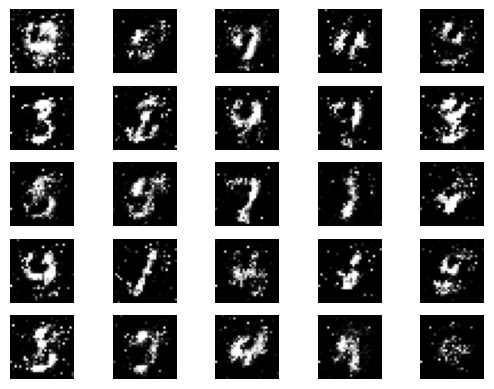

[151/400][0/16] 	Loss_D: 0.4733	Loss_G: -0.0721	D(x): 0.8680	D(G(z)): 0.2419
[152/400][0/16] 	Loss_D: 0.4481	Loss_G: -0.0685	D(x): 0.8333	D(G(z)): 0.1779
[153/400][0/16] 	Loss_D: 0.5105	Loss_G: -0.1053	D(x): 0.8795	D(G(z)): 0.2772
[154/400][0/16] 	Loss_D: 0.4056	Loss_G: -0.0851	D(x): 0.8618	D(G(z)): 0.1906
[155/400][0/16] 	Loss_D: 0.3994	Loss_G: -0.0813	D(x): 0.8549	D(G(z)): 0.1751
[156/400][0/16] 	Loss_D: 0.4400	Loss_G: -0.2983	D(x): 0.7685	D(G(z)): 0.1143
[157/400][0/16] 	Loss_D: 0.4016	Loss_G: -0.1599	D(x): 0.8615	D(G(z)): 0.1878
[158/400][0/16] 	Loss_D: 0.6251	Loss_G: -0.0568	D(x): 0.9357	D(G(z)): 0.3642
[159/400][0/16] 	Loss_D: 0.9943	Loss_G: -0.0139	D(x): 0.9433	D(G(z)): 0.5340
[160/400][0/16] 	Loss_D: 0.5709	Loss_G: -0.0191	D(x): 0.9347	D(G(z)): 0.3519
[161/400][0/16] 	Loss_D: 0.5148	Loss_G: -0.0896	D(x): 0.8984	D(G(z)): 0.3000
[162/400][0/16] 	Loss_D: 0.3301	Loss_G: -0.1245	D(x): 0.8152	D(G(z)): 0.0545
[163/400][0/16] 	Loss_D: 0.5989	Loss_G: -0.1938	D(x): 0.7931	D(G(z)): 0.2184

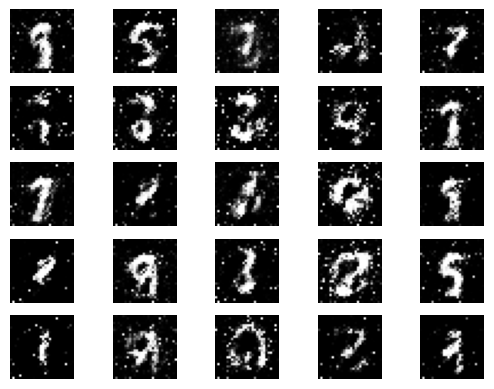

[176/400][0/16] 	Loss_D: 0.7284	Loss_G: -0.3603	D(x): 0.6396	D(G(z)): 0.0241
[177/400][0/16] 	Loss_D: 0.5739	Loss_G: -0.0309	D(x): 0.9678	D(G(z)): 0.3676
[178/400][0/16] 	Loss_D: 0.6960	Loss_G: -0.0248	D(x): 0.9379	D(G(z)): 0.4051
[179/400][0/16] 	Loss_D: 0.7222	Loss_G: -0.4887	D(x): 0.5956	D(G(z)): 0.0265
[180/400][0/16] 	Loss_D: 0.4201	Loss_G: -0.0296	D(x): 0.9442	D(G(z)): 0.2785
[181/400][0/16] 	Loss_D: 0.4869	Loss_G: -0.0168	D(x): 0.9071	D(G(z)): 0.2835
[182/400][0/16] 	Loss_D: 0.2904	Loss_G: -0.1251	D(x): 0.8499	D(G(z)): 0.0816
[183/400][0/16] 	Loss_D: 1.6257	Loss_G: -1.0641	D(x): 0.3800	D(G(z)): 0.0065
[184/400][0/16] 	Loss_D: 0.4195	Loss_G: -0.2070	D(x): 0.8723	D(G(z)): 0.2040
[185/400][0/16] 	Loss_D: 0.4963	Loss_G: -0.2003	D(x): 0.7348	D(G(z)): 0.0681
[186/400][0/16] 	Loss_D: 0.2583	Loss_G: -0.0810	D(x): 0.9084	D(G(z)): 0.1174
[187/400][0/16] 	Loss_D: 2.5676	Loss_G: -1.8285	D(x): 0.2784	D(G(z)): 0.0013
[188/400][0/16] 	Loss_D: 0.4827	Loss_G: -0.1940	D(x): 0.8771	D(G(z)): 0.2386

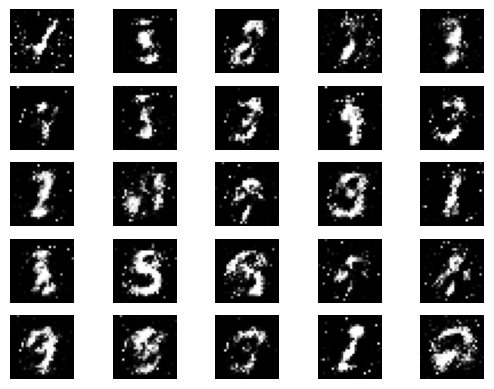

[201/400][0/16] 	Loss_D: 0.5640	Loss_G: -0.0247	D(x): 0.9357	D(G(z)): 0.3027
[202/400][0/16] 	Loss_D: 0.7338	Loss_G: -0.2163	D(x): 0.7977	D(G(z)): 0.2347
[203/400][0/16] 	Loss_D: 0.4113	Loss_G: -0.1237	D(x): 0.8826	D(G(z)): 0.1762
[204/400][0/16] 	Loss_D: 0.4878	Loss_G: -0.0850	D(x): 0.8922	D(G(z)): 0.2469
[205/400][0/16] 	Loss_D: 1.1752	Loss_G: -0.6272	D(x): 0.4597	D(G(z)): 0.0304
[206/400][0/16] 	Loss_D: 0.4780	Loss_G: -0.0536	D(x): 0.9213	D(G(z)): 0.2707
[207/400][0/16] 	Loss_D: 0.5864	Loss_G: -0.6021	D(x): 0.6776	D(G(z)): 0.0578
[208/400][0/16] 	Loss_D: 0.3657	Loss_G: -0.0824	D(x): 0.8249	D(G(z)): 0.1067
[209/400][0/16] 	Loss_D: 0.5277	Loss_G: -0.2419	D(x): 0.7262	D(G(z)): 0.0806
[210/400][0/16] 	Loss_D: 0.3985	Loss_G: -0.1120	D(x): 0.8066	D(G(z)): 0.1144
[211/400][0/16] 	Loss_D: 0.7858	Loss_G: -0.0067	D(x): 0.9668	D(G(z)): 0.4299
[212/400][0/16] 	Loss_D: 0.2461	Loss_G: -0.1153	D(x): 0.9051	D(G(z)): 0.1153
[213/400][0/16] 	Loss_D: 0.2770	Loss_G: -0.1170	D(x): 0.8855	D(G(z)): 0.1122

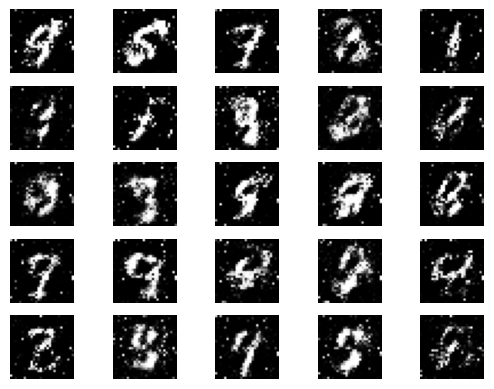

[226/400][0/16] 	Loss_D: 0.3492	Loss_G: -0.0563	D(x): 0.8591	D(G(z)): 0.1336
[227/400][0/16] 	Loss_D: 0.2817	Loss_G: -0.0876	D(x): 0.8761	D(G(z)): 0.1022
[228/400][0/16] 	Loss_D: 0.8483	Loss_G: -0.0375	D(x): 0.9409	D(G(z)): 0.4488
[229/400][0/16] 	Loss_D: 0.2916	Loss_G: -0.0759	D(x): 0.8564	D(G(z)): 0.0908
[230/400][0/16] 	Loss_D: 1.1597	Loss_G: -0.7549	D(x): 0.4738	D(G(z)): 0.0136
[231/400][0/16] 	Loss_D: 0.8556	Loss_G: -0.0131	D(x): 0.9291	D(G(z)): 0.4410
[232/400][0/16] 	Loss_D: 0.4394	Loss_G: -0.0726	D(x): 0.9010	D(G(z)): 0.2378
[233/400][0/16] 	Loss_D: 0.4693	Loss_G: -0.0131	D(x): 0.9520	D(G(z)): 0.2963
[234/400][0/16] 	Loss_D: 3.6077	Loss_G: -0.0031	D(x): 0.9987	D(G(z)): 0.9392
[235/400][0/16] 	Loss_D: 0.5625	Loss_G: -0.6713	D(x): 0.7005	D(G(z)): 0.0661
[236/400][0/16] 	Loss_D: 0.4431	Loss_G: -0.2423	D(x): 0.9059	D(G(z)): 0.2518
[237/400][0/16] 	Loss_D: 0.3353	Loss_G: -0.1209	D(x): 0.9014	D(G(z)): 0.1743
[238/400][0/16] 	Loss_D: 0.2718	Loss_G: -0.0942	D(x): 0.8686	D(G(z)): 0.0835

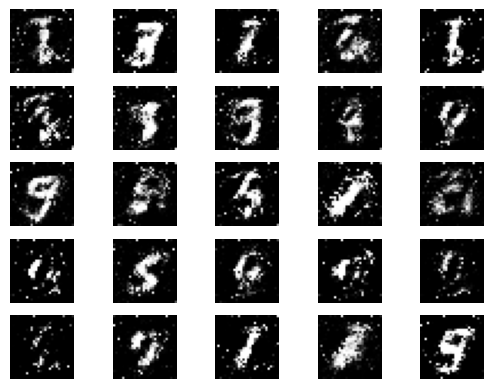

[251/400][0/16] 	Loss_D: 0.4306	Loss_G: -0.0485	D(x): 0.9211	D(G(z)): 0.2127
[252/400][0/16] 	Loss_D: 0.7920	Loss_G: -0.0120	D(x): 0.9444	D(G(z)): 0.4343
[253/400][0/16] 	Loss_D: 0.4179	Loss_G: -0.1493	D(x): 0.8435	D(G(z)): 0.1677
[254/400][0/16] 	Loss_D: 0.3744	Loss_G: -0.1470	D(x): 0.8878	D(G(z)): 0.1874
[255/400][0/16] 	Loss_D: 0.1959	Loss_G: -0.0655	D(x): 0.9109	D(G(z)): 0.0839
[256/400][0/16] 	Loss_D: 0.2779	Loss_G: -0.0860	D(x): 0.9084	D(G(z)): 0.1235
[257/400][0/16] 	Loss_D: 0.4511	Loss_G: -0.0522	D(x): 0.9337	D(G(z)): 0.2740
[258/400][0/16] 	Loss_D: 1.2567	Loss_G: -0.4596	D(x): 0.4635	D(G(z)): 0.0170
[259/400][0/16] 	Loss_D: 0.4527	Loss_G: -0.0997	D(x): 0.9018	D(G(z)): 0.2391
[260/400][0/16] 	Loss_D: 0.2952	Loss_G: -0.0754	D(x): 0.8741	D(G(z)): 0.1223
[261/400][0/16] 	Loss_D: 0.2585	Loss_G: -0.2045	D(x): 0.8535	D(G(z)): 0.0549
[262/400][0/16] 	Loss_D: 1.1585	Loss_G: -0.3739	D(x): 0.5528	D(G(z)): 0.1165
[263/400][0/16] 	Loss_D: 0.4916	Loss_G: -0.3728	D(x): 0.7790	D(G(z)): 0.1411

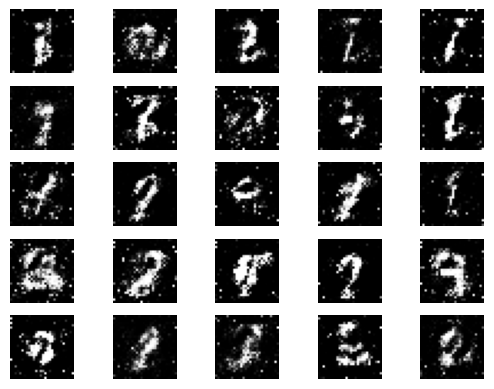

[276/400][0/16] 	Loss_D: 0.4115	Loss_G: -0.2350	D(x): 0.8984	D(G(z)): 0.2151
[277/400][0/16] 	Loss_D: 0.3191	Loss_G: -0.1348	D(x): 0.8613	D(G(z)): 0.0971
[278/400][0/16] 	Loss_D: 0.4215	Loss_G: -0.0729	D(x): 0.9319	D(G(z)): 0.2580
[279/400][0/16] 	Loss_D: 0.1915	Loss_G: -0.0426	D(x): 0.9370	D(G(z)): 0.1087
[280/400][0/16] 	Loss_D: 1.3289	Loss_G: -1.6868	D(x): 0.4400	D(G(z)): 0.0088
[281/400][0/16] 	Loss_D: 0.7155	Loss_G: -0.0181	D(x): 0.9605	D(G(z)): 0.4272
[282/400][0/16] 	Loss_D: 0.4569	Loss_G: -0.1470	D(x): 0.9075	D(G(z)): 0.2445
[283/400][0/16] 	Loss_D: 0.6504	Loss_G: -0.2599	D(x): 0.6516	D(G(z)): 0.0525
[284/400][0/16] 	Loss_D: 2.2433	Loss_G: -0.0342	D(x): 0.9927	D(G(z)): 0.8055
[285/400][0/16] 	Loss_D: 0.3688	Loss_G: -0.1370	D(x): 0.8319	D(G(z)): 0.1267
[286/400][0/16] 	Loss_D: 0.8460	Loss_G: -0.3287	D(x): 0.5676	D(G(z)): 0.0224
[287/400][0/16] 	Loss_D: 0.4821	Loss_G: -0.2267	D(x): 0.7903	D(G(z)): 0.1539
[288/400][0/16] 	Loss_D: 0.5980	Loss_G: -0.1379	D(x): 0.7490	D(G(z)): 0.1351

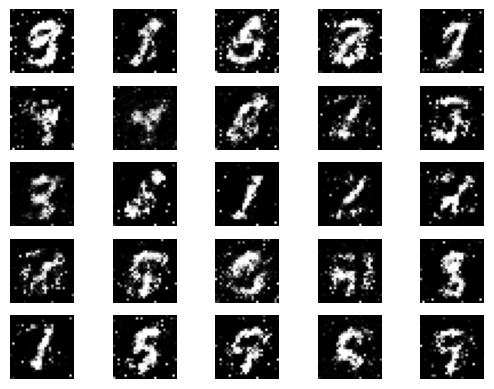

[301/400][0/16] 	Loss_D: 0.2460	Loss_G: -0.1791	D(x): 0.8925	D(G(z)): 0.1018
[302/400][0/16] 	Loss_D: 0.5182	Loss_G: -0.0119	D(x): 0.9781	D(G(z)): 0.3366
[303/400][0/16] 	Loss_D: 0.3855	Loss_G: -0.1402	D(x): 0.8956	D(G(z)): 0.1854
[304/400][0/16] 	Loss_D: 0.4779	Loss_G: -0.3438	D(x): 0.7301	D(G(z)): 0.0442
[305/400][0/16] 	Loss_D: 0.2645	Loss_G: -0.1341	D(x): 0.8585	D(G(z)): 0.0589
[306/400][0/16] 	Loss_D: 0.1922	Loss_G: -0.1058	D(x): 0.9208	D(G(z)): 0.0833
[307/400][0/16] 	Loss_D: 0.3071	Loss_G: -0.2643	D(x): 0.8467	D(G(z)): 0.0907
[308/400][0/16] 	Loss_D: 0.9495	Loss_G: -0.8688	D(x): 0.5364	D(G(z)): 0.0158
[309/400][0/16] 	Loss_D: 0.3273	Loss_G: -0.0467	D(x): 0.9471	D(G(z)): 0.1899
[310/400][0/16] 	Loss_D: 0.3696	Loss_G: -0.2678	D(x): 0.7785	D(G(z)): 0.0484
[311/400][0/16] 	Loss_D: 1.5136	Loss_G: -1.7804	D(x): 0.3484	D(G(z)): 0.0073
[312/400][0/16] 	Loss_D: 0.5485	Loss_G: -0.0221	D(x): 0.9497	D(G(z)): 0.3401
[313/400][0/16] 	Loss_D: 0.4445	Loss_G: -0.2017	D(x): 0.7924	D(G(z)): 0.1149

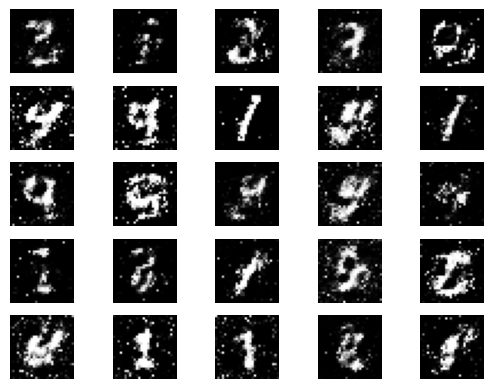

[326/400][0/16] 	Loss_D: 0.7404	Loss_G: -0.0746	D(x): 0.9116	D(G(z)): 0.4078
[327/400][0/16] 	Loss_D: 0.7684	Loss_G: -0.4401	D(x): 0.6127	D(G(z)): 0.0367
[328/400][0/16] 	Loss_D: 0.3648	Loss_G: -0.1759	D(x): 0.7990	D(G(z)): 0.0810
[329/400][0/16] 	Loss_D: 1.4299	Loss_G: -0.0292	D(x): 0.9610	D(G(z)): 0.6562
[330/400][0/16] 	Loss_D: 0.4775	Loss_G: -0.1506	D(x): 0.8455	D(G(z)): 0.2148
[331/400][0/16] 	Loss_D: 0.5966	Loss_G: -0.2018	D(x): 0.9024	D(G(z)): 0.3147
[332/400][0/16] 	Loss_D: 0.4505	Loss_G: -0.3591	D(x): 0.7336	D(G(z)): 0.0570
[333/400][0/16] 	Loss_D: 0.6107	Loss_G: -0.3517	D(x): 0.6819	D(G(z)): 0.0665
[334/400][0/16] 	Loss_D: 0.9362	Loss_G: -0.5811	D(x): 0.5370	D(G(z)): 0.0385
[335/400][0/16] 	Loss_D: 0.4554	Loss_G: -0.1392	D(x): 0.8451	D(G(z)): 0.1895
[336/400][0/16] 	Loss_D: 0.3916	Loss_G: -0.1192	D(x): 0.8637	D(G(z)): 0.1696
[337/400][0/16] 	Loss_D: 0.4188	Loss_G: -0.2294	D(x): 0.8467	D(G(z)): 0.1712
[338/400][0/16] 	Loss_D: 0.5163	Loss_G: -0.2143	D(x): 0.8115	D(G(z)): 0.2180

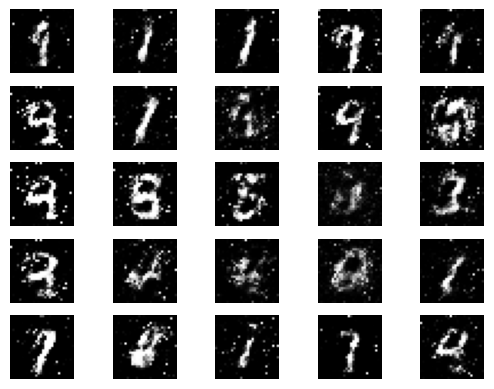

[351/400][0/16] 	Loss_D: 0.5033	Loss_G: -0.1721	D(x): 0.7231	D(G(z)): 0.0613
[352/400][0/16] 	Loss_D: 0.3827	Loss_G: -0.1457	D(x): 0.8663	D(G(z)): 0.1783
[353/400][0/16] 	Loss_D: 0.4598	Loss_G: -0.0961	D(x): 0.9110	D(G(z)): 0.2644
[354/400][0/16] 	Loss_D: 0.5111	Loss_G: -0.4348	D(x): 0.7262	D(G(z)): 0.0823
[355/400][0/16] 	Loss_D: 0.4160	Loss_G: -0.2292	D(x): 0.7663	D(G(z)): 0.0697
[356/400][0/16] 	Loss_D: 0.4128	Loss_G: -0.3107	D(x): 0.7897	D(G(z)): 0.0873
[357/400][0/16] 	Loss_D: 0.3702	Loss_G: -0.0883	D(x): 0.8419	D(G(z)): 0.1219
[358/400][0/16] 	Loss_D: 0.7431	Loss_G: -0.0672	D(x): 0.9505	D(G(z)): 0.4339
[359/400][0/16] 	Loss_D: 0.3357	Loss_G: -0.1640	D(x): 0.8373	D(G(z)): 0.1110
[360/400][0/16] 	Loss_D: 0.5204	Loss_G: -0.0744	D(x): 0.8699	D(G(z)): 0.2754
[361/400][0/16] 	Loss_D: 0.3983	Loss_G: -0.2030	D(x): 0.8495	D(G(z)): 0.1571
[362/400][0/16] 	Loss_D: 0.3708	Loss_G: -0.1187	D(x): 0.8579	D(G(z)): 0.1391
[363/400][0/16] 	Loss_D: 0.6057	Loss_G: -0.0895	D(x): 0.8107	D(G(z)): 0.2448

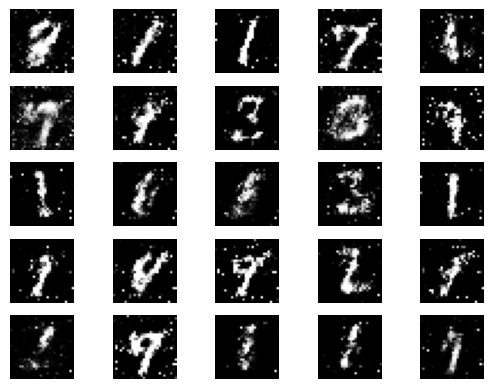

[376/400][0/16] 	Loss_D: 0.5530	Loss_G: -0.4288	D(x): 0.7881	D(G(z)): 0.1880
[377/400][0/16] 	Loss_D: 1.0647	Loss_G: -0.0345	D(x): 0.9313	D(G(z)): 0.5239
[378/400][0/16] 	Loss_D: 0.4767	Loss_G: -0.2045	D(x): 0.7959	D(G(z)): 0.1748
[379/400][0/16] 	Loss_D: 1.7778	Loss_G: -0.0243	D(x): 0.9778	D(G(z)): 0.7423
[380/400][0/16] 	Loss_D: 0.6749	Loss_G: -0.4674	D(x): 0.6531	D(G(z)): 0.1097
[381/400][0/16] 	Loss_D: 0.6877	Loss_G: -0.0357	D(x): 0.9347	D(G(z)): 0.4170
[382/400][0/16] 	Loss_D: 0.4868	Loss_G: -0.1226	D(x): 0.8876	D(G(z)): 0.2488
[383/400][0/16] 	Loss_D: 0.5084	Loss_G: -0.0932	D(x): 0.8401	D(G(z)): 0.1969
[384/400][0/16] 	Loss_D: 0.4723	Loss_G: -0.1504	D(x): 0.8531	D(G(z)): 0.2217
[385/400][0/16] 	Loss_D: 0.4024	Loss_G: -0.2674	D(x): 0.8660	D(G(z)): 0.1825
[386/400][0/16] 	Loss_D: 0.4890	Loss_G: -0.1439	D(x): 0.8765	D(G(z)): 0.2360
[387/400][0/16] 	Loss_D: 0.8439	Loss_G: -0.0394	D(x): 0.9237	D(G(z)): 0.4524
[388/400][0/16] 	Loss_D: 0.4835	Loss_G: -0.2716	D(x): 0.7664	D(G(z)): 0.1135

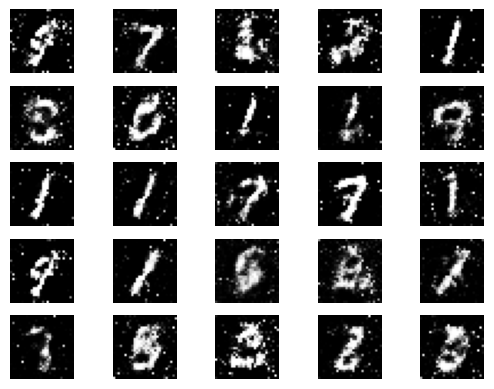

In [49]:

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []

sample_interval=25

print("Starting Training")
# For each epoch
for epoch in range(n_epochs):
  # For each batch in the dataloader
  for i, data in enumerate(mnist_train_loader, 0):
    for iter_inner in range(0,n_iters_inner):
        
      ############################
      ### Train discriminator
      ############################
      ## Train with true data batch
      disc_model.zero_grad()
      # create true data and labels 
      true_imgs = data[0].to(device)
      true_labels = torch.ones(true_imgs.shape[0],1).to(device)
      # put true data through discriminator
      d_output_true = disc_model(true_imgs)
      # bce loss on true data
      d_loss_true = bce_criterion(d_output_true, true_labels)
      # backpropagation for discriminator, true loss
      d_loss_true.backward()
      disc_true_value = d_output_true.mean().item()

      ## Train with fake data batch
      # create fake data and labels
      # generate batch of random latent vectors
      z_latent_noise =  torch.randn(true_imgs.shape[0], 1, z_dim, dtype=torch.float, device=device) #np.random.normal(0, 1, (true_imgs.shape[0], z_dim))
      # Generate batch of fake images
      fake_imgs = gen_model(z_latent_noise)
      fake_labels = torch.zeros(fake_imgs.shape[0],1).to(device)
      # put fake data through discriminator
      disc_output_fake = disc_model(fake_imgs)
      # bce loss on fake data
      disc_loss_fake = bce_criterion(disc_output_fake, fake_labels)
      # backpropagation for discriminator, fake loss
      disc_loss_fake.backward()
      disc_fake_value = disc_output_fake.mean().item()
      # Update discriminator
      optimizer_disc.step()

      d_loss_total = d_loss_true+disc_loss_fake

    ############################
    ### Train generator
    ############################
    # generate batch of random latent vectors
    z_latent_noise =  torch.randn(true_imgs.shape[0], 1, z_dim, dtype=torch.float, device=device) #np.random.normal(0, 1, (true_imgs.shape[0], z_dim))
    # Generate batch of fake images
    fake_imgs = gen_model(z_latent_noise)
    gen_model.zero_grad()
    # We have updated the discriminator, so we need to update the output of the discriminator
    disc_gen_output_fake = disc_model(fake_imgs)
    # Generator loss, using the custom loss
    g_loss = loss_fn_gen(disc_gen_output_fake)
    # backpropagation for generator
    g_loss.backward()
    #D_G_z2 = output.mean().item()
    # Update generator
    optimizer_gen.step()

    # Output training stats
    if i % 200 == 0:
      print('[%d/%d][%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
      % (epoch, n_epochs, i, len(mnist_train_loader),d_loss_total.item(), g_loss.item(), disc_true_value, disc_fake_value ))

    # Save Losses for plotting later
    G_losses.append(g_loss.item())
    D_losses.append(d_loss_total.item())

  if(epoch % sample_interval == 0):
    sample_images(gen_model,z_dim, rand_seed=30)

# end samples
sample_images(gen_model,z_dim, rand_seed=30)


## 6/ Navigating in the latent space

One of the main interests in the latent space is to be able to __navigate__ in it. For instance, one operation which is very common is to take two points $z_0$ and $z_1$ and to interpolate between the two. The images resulting from the generation of the interpolated points should ideally be a mix between the two initial points. 

The simplest method of interpolation is simply linear interpolation along the line connecting the two points. Obviously, this supposes that the latent space is linear in some sense, which may not be true, but we are going to take this approach here. 

First, find two inital points $z_0$ and $z_1$ which you feel represent two different digits well, and display their resulting generated images.  

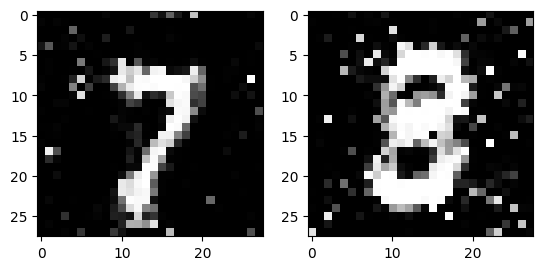

In [75]:
# first image
random_seed = 35 # change this seed to find the best image
torch.manual_seed(random_seed)
z_0 = torch.randn(1, 1, z_dim, dtype=torch.float, device=device) #np.random.normal(0, 1, (1, z_dim))
x_0 = gen_model(z_0)

random_seed = 176 # change this seed to find the best image
torch.manual_seed(random_seed)
z_1 =  torch.randn(1, 1, z_dim, dtype=torch.float, device=device) #np.random.normal(0, 1, (1, z_dim))
x_1 = gen_model(z_1)

# display images
fig, axs = plt.subplots(1,2)
axs[0].imshow(x_0.cpu().detach().numpy().squeeze(), cmap='gray')
axs[1].imshow(x_1.cpu().detach().numpy().squeeze(), cmap='gray')
plt.show()


Now, carry out the interpolation between these two points. You should __include__ the starting and ending codes $z_0$ and $z_1$. Display the results.

In [76]:
n_interpolation = 20

# linear interpolation
x_interpolation = torch.zeros(n_interpolation, 1, 28, 28)
for i in range(n_interpolation):
    alpha = i/(n_interpolation-1)
    x_interpolation[i,:,:,:] = alpha*x_0 + (1-alpha)*x_1

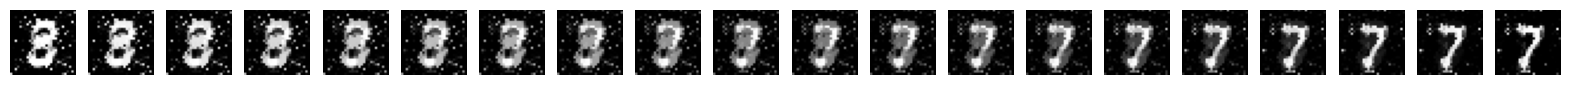

In [77]:
# display results

fig, axs = plt.subplots(1, n_interpolation,figsize=(20,20))
for i in range(n_interpolation):
  #black and white images
  axs[i].imshow(x_interpolation[i,:,:,:].cpu().detach().numpy().squeeze(), cmap='gray')
  axs[i].axis('off')
plt.show()

What do you think of the quality of the output images ?

__Answer__

## 7/ Evaluation of navigation

Now, we are going to evaluate this navigation. We will investigate two properties:

- 1/ We are going to see whether by navigating between two points, the model produces images which are categorised in either of the classes (beginning class or end class), or if it traverses a region which is categorised in another class;
- 2/ We are going to see whether the confidence of a classification network in different regions varies much. In other words, when we navigate in the latent space, do we go into zones which do not correspond to any number (according to the classification network) ? 

For this, we will first need a classification network. Take the code from the last lab work on variational autoencoders, and extract the section where we trained a classifier on mnist. Here is the architecture we used:

- conv2d, filter size  3×3 , 32 filters, stride=(2,2), padding="SAME"
- ReLU
- conv2d, filter size  3×3 , 32 filters, stride=(2,2), padding="SAME"
- ReLU
- MaxPool2D, stride=(2,2)
- Flatten
- Dense layer

In [78]:
# define mnist classifier model, loss function, optimiser and the function 'get_accuracy'

learning_rate = 0.01
n_epochs = 20
batch_size = 64
nb_classes = int(mnist_trainset.targets.max()+1)

# number of convolutional filters to use
nb_filters = 32
# convolution kernel size
kernel_size = (3, 3)
# size of pooling area for max pooling
pool_size = (2, 2)

# --- Size of the successive layers
n_h_0 = 1 #greyscale input images
n_h_1 = nb_filters
n_h_2 = nb_filters

mnist_classification_model = torch.nn.Sequential(
    torch.nn.Conv2d(n_h_0, n_h_1, kernel_size=kernel_size, padding="same"),
    torch.nn.ReLU(),
    torch.nn.Conv2d(n_h_1, n_h_2, kernel_size=kernel_size, padding="same"),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=pool_size, stride=(2, 2)),
    torch.nn.Flatten(),
    torch.nn.Linear(784*8, nb_classes)
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_classification_model.parameters(), lr=learning_rate)

def get_accuracy(x_pred,x_label):
  acc = torch.sum(x_pred == x_label)/(x_pred.shape[0])
  return acc

In [79]:
# training the classifier

train_losses=[]
valid_losses=[]

for epoch in range(0,n_epochs):
  train_loss=0.0

  for batch_idx, (imgs, labels) in enumerate(mnist_train_loader):

    # set the gradients back to 0
    optimizer.zero_grad()
    predict=mnist_classification_model(imgs)
    # apply loss function
    loss=criterion(predict,labels)
    acc = get_accuracy(torch.argmax(predict,dim=1),labels)
    # backpropagation
    loss.backward()
    optimizer.step()
    train_loss=loss.item()
  print('Epoch:{} Train Loss:{:.4f} Accuracy:{:.4f}'.format(epoch,train_loss/imgs.shape[0],acc))

Epoch:0 Train Loss:0.0063 Accuracy:0.9500
Epoch:1 Train Loss:0.0136 Accuracy:0.8250
Epoch:2 Train Loss:0.0020 Accuracy:1.0000
Epoch:3 Train Loss:0.0091 Accuracy:0.9250
Epoch:4 Train Loss:0.0034 Accuracy:0.9750
Epoch:5 Train Loss:0.0024 Accuracy:0.9750
Epoch:6 Train Loss:0.0008 Accuracy:1.0000
Epoch:7 Train Loss:0.0002 Accuracy:1.0000
Epoch:8 Train Loss:0.0001 Accuracy:1.0000
Epoch:9 Train Loss:0.0001 Accuracy:1.0000
Epoch:10 Train Loss:0.0002 Accuracy:1.0000
Epoch:11 Train Loss:0.0001 Accuracy:1.0000
Epoch:12 Train Loss:0.0000 Accuracy:1.0000
Epoch:13 Train Loss:0.0000 Accuracy:1.0000
Epoch:14 Train Loss:0.0000 Accuracy:1.0000
Epoch:15 Train Loss:0.0000 Accuracy:1.0000
Epoch:16 Train Loss:0.0000 Accuracy:1.0000
Epoch:17 Train Loss:0.0000 Accuracy:1.0000
Epoch:18 Train Loss:0.0000 Accuracy:1.0000
Epoch:19 Train Loss:0.0000 Accuracy:1.0000


### 7.1/ Evaluation of navigation part 1

Now, create a function which returns the classification returned by this network on mnist images. Remember, the classification model above returns the values __before__ the softmax is applied, and here we want the argmax, rather than the maximum probability. __Note__: the torch.max function returns a tuple: (max_values, max_indices).


In [80]:
def predict_mnist_class(imgs_in,classification_model):
  output_classes = torch.argmax(classification_model(imgs_in),dim=1)
  return(output_classes)

Carry out and print the classification of your interpolated latent space images. What are your remarks ? Does the latent space navigation traverse regions with classes other than those of $z_0$ and $z_1$ ?

In [81]:
z_classes = predict_mnist_class(x_interpolation,mnist_classification_model)
print(z_classes)

tensor([8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7])


__Answer__

### 7.2/ Evaluation of navigation part 2

Even though the network may predict coherent image classes during the navigation, it may predict these classes with different confidences. Ideally, we would like the latent space to contain codes which produce images of constant quality. Therefore, as mentioned above, we want to check these prediction confidences during navigation on our GAN.

Carry this out now. First of all, define a function which, instead of funding the output *classes* of the interpolations, find the *probability* of the most likely class (the same operation as in the lab on variational autoencoders).


In [ ]:
def predict_mnist_confidence(imgs_in,classification_model):
  output_classes = torch.max(classification_model(imgs_in),dim=1)
  return(output_classes)

Using this function, carry out the second evaluation on the images generated by interpolated latent codes.

In [ ]:
z_confidence = ... #FILL IN HERE
print(z_confidence)

Does the confidence change greatly during interpolation ? Does the navigation go through zones where the classification is not confident ? Why do you think this is ? (think about the form/shape of the latent space).

__Answer__

# __Optional__ : Training on CIFAR

If you want to try another, more challenging database, use the above code and modify it to carry out the GAN training on the CIFAR10 database. Note, it can take a long time to get good results

First, we download the data.

In [ ]:
# convert input to Pytorch tensors
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

# extract mnist data
cifar_trainset = datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
print(cifar_trainset)

#create data loader with smaller dataset size
max_cifar_size = 2000
cifar_trainset_reduced = torch.utils.data.random_split(cifar_trainset, [max_cifar_size, len(cifar_trainset)-max_cifar_size])[0] 
cifar_train_loader = torch.utils.data.DataLoader(cifar_trainset_reduced, batch_size=64, shuffle=True)

# download test dataset
cifar_testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
cifar_test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=64, shuffle=True)

n_rows = 32
n_cols = 32
n_channels = 3
n_pixels = n_rows*n_cols

img_shape = (n_rows, n_cols, n_channels)

Now, we can redefine the hyper-parameters of the model (change if you wish)

In [ ]:
## GAN parameters
z_dim = 10
batch_size = 64
n_epochs = 300
## parameters for training
n_iters_inner=1	#number of internal loops
# Learning rate for optimizers
lr = 0.0002
beta_1 = 0.5

For this case of CIFAR, implement the following architecture :

- Generator :
  - Dense layer to size 1024
  - Leaky ReLU ($\alpha=0.2$)
  - Reshape, to size $4 \times 4 \times64$
  - % size = $4\times4\times64$
  - Conv2d, n_channels=16,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size = $8\times 8\times 16$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2d, n_channels=16,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size=$16 \times 16 \times 16$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2d, n_channels=3,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size = $32 \times 32 \times 3$
  - Tanh activation ( you can use ```Activation('tanh')```)

- Discriminator :
  - % input size : $32 \times 32 \times 3$
  - Conv2D, 32 filters, kernel size = (3,3), strides = (1,1),padding = same
  - % size $32 \times 32 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 32 filters, kernel size = (3,3), strides = (2,2),padding = same
  - %size : $16 \times 16 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 64 filters, kernel size = (3,3), strides = (2,2),padding = same
  - % size : $8 \times 8 \times 64$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 32 filters, kernel size = (3,3), strides = (2,2),padding = same
  - % size : $4 \times 4 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Flatten
  - Dense layer to size 1
  - Sigmoid activation

  Implement this architecture below, and train the GAN. 

In [ ]:
# GAN implementation

# FILL IN HERE

Now, carry out the training (use code above)

In [ ]:
# training code

# FILL IN HERE